/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in power


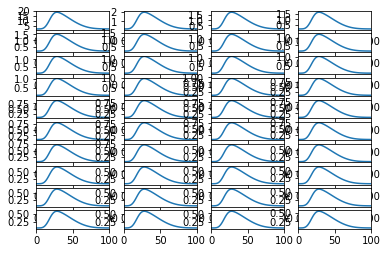

In [30]:
# -*- coding: utf-8 -*-
"""python_refactor.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1DUV_-4bZubkROAm89OAcHXsm_ehk1M2L
"""

# import required modules
from __future__ import division
import sys
import numpy as np
import pandas as pd
from scipy.optimize import fmin
from scipy import stats
from math import ceil
#from plotly.offline import plot
#import plotly.graph_objs as go
import matplotlib.pyplot as plt
import csv
import os
GRAVITY = 9.81
MANNING_SI = 1.00
MANNING_UK = 1.49
'''Actual value: 1.4859185775 = (1 / 0.3048) ** (1/3)'''

def y_direct(B, n, S0, Q):
    ''' function to compute error in depth calculation for a guessed depth compared to a calculated depth for a given flow.
        Uses scipy.optimize fmin '''
    y_optimum = fmin(flow_min, Q/B/3, args=(n, S0, Q, B, MANNING_UK), full_output=True, disp=False)
    return float(y_optimum[0])

def flow_min(y, n, S0, Q, B, k = MANNING_SI):
    ''' computes the error term comparing the Manning's computed depth with the given Q '''  
    epsilon = np.abs(Manning_Q(y, n, S0, B, k) - Q)
    return epsilon

def Manning_Q(y, n, S0, B, k = MANNING_SI):
    ''' compute flow using Manning's equation ''' 
    return (k/n)*(S0**0.5)*((B*y)**(5/3))/((B+y)**(2/3))

# Generate_Hydrograph from Maryam Asgari Lamjiri and Kelly Flint
# NWC Summer institute coordinators 2019
def Generate_Hydrograph (Num_TimeStep,Steady_time,width,Skewness,QMax):
    # Steady_time += 359    
    XX = np.linspace(-5,5,Num_TimeStep)
    Steady_t = -5 + Steady_time/Num_TimeStep*10
    t = (XX - Steady_t)/width
    P = 2.0 / width * stats.norm.pdf(t) * stats.norm.cdf(Skewness*t)
    Q = (QMax-100) * P/np.max(P)+100
    # plt.plot(np.arange(0,Num_TimeStep),Q)
    return Q


#########################################################
#            FINITE DIFFERENCE METHOD                   #
#                                                       #
#  A program for one dimensional flow in open channels  #
#                                                       #
#########################################################
    
class Network:
    '''Class definition for reaches related as part of a computational scheme for 
       open channel routing '''
    def __init__(self):
        '''initialize a new Network of sections/reaches'''
        self.sections = []
        self.time_list = [] # TODO: this initialization could be for a datetime series to contain the timestamps
        self.upstream_flow_ts = []
        self.downstream_stage_ts = []
        
    def input_and_initialize_simple(self):
        pass
    
    def compute_initial_state(self):
        pass 

    def compute_time_steps(self): 
        '''This function can operate with 
        1) Nt and dt (number of time steps and size of time step) and a pointer to boundary information
        2) List of times and a pointer to boundary information
        3) an initial time, a list of time deltas, and a corresponding list of boundary conditions 
         but since they really all boil down to the last situation, we'll just 
         make it work for #3 and then have other translator methods that create these.'''

        for j, t in enumerate(self.time_list):
            #print(j+1 , len(self.time_list), len(self.upstream_flow_ts), len(self.downstream_stage_ts))
            if j+1 < len(self.time_list):
                self.compute_next_time_step_state(j, self.upstream_flow_ts[j], self.upstream_flow_ts[j+1], self.downstream_stage_ts[j], self.downstream_stage_ts[j+1])
                # self.compute_next_time_step_state(t, j)

    def compute_next_time_step_state(self, j, t0, t1, upstream_flow_current,
                                     upstream_flow_next, downstream_stage_current,
                                     downstream_stage_next): # Will be defined in child classes
    # def compute_next_time_step_state(self, j, t)
        pass

    class TimeStep:
    #TODO: QUESTION FOR Nick
        ''' When we are passing the time steps out to the Fortran module, 
        we only want to pass one timestep at a time and receive another one back. 
        How does that happen best? '''
        def __init__(self, time_step = None, new_flow = None, new_depth = None):
            # Per-time-step at-a-section properties
            self.time = time_step 
            self.flow = new_flow
            self.depth = new_depth

            # Per-time-step downstream reach properties
            self.friction_slope_ds = 0

    def add_time_step(self, section, new_flow, new_depth):
        section.time_steps.append(self.TimeStep(new_flow = new_flow, new_depth=new_depth))

    def add_upstream_boundary_condition_time_step(self, section, upstream_flow):
        section.time_steps.append(self.TimeStep(new_flow = upstream_flow))

    def add_downstream_boundary_condition_time_step(self, section, downstream_depth):
        section.time_steps.append(self.TimeStep(new_depth = downstream_depth))

    def add_normal_depth_time_step(self, section, new_flow):
        new_depth = y_direct(section.bottom_width, section.manning_n_ds, section.bed_slope_ds, new_flow)
        section.time_steps.append(self.TimeStep(new_flow=new_flow, new_depth=new_depth))
    
class DummyNetwork(Network):

    #TODO: These Input and Initialize methods could be diefferent methods within the Network class
    def input_and_initialize(self, input_path=None, input_opt=1, output_path=None, upstream_flow_ts=None, downstream_stage_ts=None):
        ''' This input option is intended to be an extremely simple channel for testing and plotting development'''
        input_vars = {}

        self.time_list = range(101)
#        import pandas as pd
#        pandas.date_range("11:00", "21:30", freq="30min")
#        datelist = pd.date_range(pd.datetime.today(), periods=100).tolist()

        n_sections = 40
        I_UPSTREAM = n_sections - 1
        I_DOWNSTREAM = 0
    
        station_downstream = 10000
        station_upstream = 11000
        stations = np.linspace(station_downstream, station_upstream, n_sections, False)
        bottom_widths = np.linspace(100, 1000, len(stations), False)
        bottom_zs = np.linspace(0,100, len(stations), False)

        #print(NCOMP, len(stations))

        #/input_vars.update({"dxini": 1000})
        input_vars.update({"manning_n_ds": 0.035})

        for i, bw in enumerate(bottom_widths):
            # continue
            self.sections.append(Section(station=stations[i]
                                    , bottom_width=bottom_widths[i]
                                    , bottom_z = bottom_zs[i]
                                    , manning_n_ds = input_vars['manning_n_ds']))
            #print(sections[i].bed_slope_ds, sections[i].dx_ds, sections[i].bottom_z)
            if i == 0:
                # self.sections[i].dx_ds = input_vars['dxini'] #Irrelevant with the slope defined
                self.sections[i].bed_slope_ds = .0001
            else:
                self.sections[i].dx_ds = self.sections[i].station - self.sections[i-1].station
                self.sections[i].bed_slope_ds = (self.sections[i].bottom_z \
                                            - self.sections[i-1].bottom_z) \
                                            / self.sections[i].dx_ds

        #TODO: clean up this code to generate intial upstream flow and downstream stage boundary time series 
        self.upstream_flow_ts = Generate_Hydrograph(len(self.time_list) , 20 , 2 , 4 , 5000)
        self.downstream_stage_ts = [y_direct(self.sections[I_DOWNSTREAM].bottom_width
                                             , self.sections[I_DOWNSTREAM].manning_n_ds
                                             , self.sections[I_DOWNSTREAM].bed_slope_ds
                                             , q ) for q in self.upstream_flow_ts]
        # print(self.upstream_flow_ts)
        # print(self.downstream_stage_ts)
        
        return input_vars

    def compute_initial_state(self):
        ''' Compute a dummy initial state
        '''
        #print(self.upstream_flow_ts)
        #print(self.downstream_stage_ts)
        for section in self.sections:
            self.add_normal_depth_time_step(section, self.upstream_flow_ts[0])

    def compute_next_time_step_state(self, j, upstream_flow_current, upstream_flow_next, downstream_stage_current, downstream_stage_next): 
        ''' the Dummy Network simply copies the current channel state to the next time step
            flow
        '''
        for section in self.sections:
            #print(j)
            self.add_normal_depth_time_step(section, upstream_flow_next)

class Section:
    #def __init__(self, bottom_width, side_slope):
    def __init__(self, bottom_width, bottom_z, comid=None, station=None, dx_ds = 10, manning_n_ds = 0.015):
        #Time independent at-a-station properties
        self.comid = comid
        self.station = station
        self.bottom_width = bottom_width
        self.bottom_z = bottom_z
        self.manning_n_ds = manning_n_ds
        self.time_steps = [] # array of values
        self.sk = MANNING_UK

        #Time independent downstream reach properties
        self.dx_ds = 0 # Distance to downstream section
        self.dbdx_ds = 0 # Distance to downstream section
        self.bed_slope_ds = 0 # Bed slope (S0) to downstream section
        #ADD NEIGHBOR Concept

def main():
    a_gravity = GRAVITY
    network = DummyNetwork()
    # network = SteadyNetwork()
    # network = MuskCNetwork()
    # network = MESHDNetwork()

    network.input_and_initialize()

    network.compute_initial_state()
    network.compute_time_steps() #TODO: ask Nick -- should this even require an argument?

    cols_for_subplots = 4
    fig, axes = plt.subplots(nrows=ceil(len(network.sections)/cols_for_subplots), ncols=cols_for_subplots, squeeze=False)

    #TODO: make plotting another method within the network
    for i, section in enumerate(network.sections):
        a = pd.Series(time_step.depth for i, time_step in enumerate(section.time_steps))
        # print(m, n)
        m = i//cols_for_subplots
        n = i%cols_for_subplots 
        a.plot(ax = axes[m,n])

    return 

if __name__ == "__main__":
    main()
